In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predic

ImportError: cannot import name 'plot_predic' from 'statsmodels.graphics.tsaplots' (/Users/eduardocampos/.pyenv/versions/3.8.12/envs/blast-from-the-forecast/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py)

In [2]:
df = pd.read_csv('../raw_data/sales_train.csv', parse_dates=['date'])

/var/folders/jd/69j4d5lx4s9dg3b1d0bfcxx80000gp/T/ipykernel_4515/838203109.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv('../raw_data/sales_train.csv', parse_dates=['date'])


In [3]:
df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-09-10,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [5]:
# Filtered item_category_id
df = df[~df['item_category_id'].isin([0, 1,10,13,32,39,42,46,50,51,52,53,59,66,68,82])]

KeyError: 'item_category_id'

In [ ]:
# Sorted date in ascending order
sales_train_df_31 = sales_train_df_31.sort_values(by='date', ascending=True, na_position='first')

In [ ]:
# Filtered shop_id
sales_train_df_31 = sales_train_df[sales_train_df['shop_id'] == 31]

In [5]:
def sales_days(df, time=["daily", 'monthly','yearly']):
    df= df.copy()
    if time == "daily":
        df.date= df.date.apply(lambda x: str(x)[:-9])
    elif time == "monthly":
    
        df.date= df.date.apply(lambda x: str(x)[:-12])
    else:
        df.date= df.date.apply(lambda x: str(x)[:4])
        
   
    df= df.groupby('date')['item_cnt_day'].sum().reset_index()
    df.date= pd.to_datetime(df.date)
        
    return df

In [6]:
df_day= sales_days(df, "daily")
df_day.head()

,date,item_cnt_day
0,2013-01-01,1951.0
1,2013-01-02,3817.0
2,2013-01-03,3846.0
3,2013-01-04,2574.0
4,2013-01-05,4863.0


In [7]:
df_month=sales_days(df,'monthly')
df_month.head()

,date,item_cnt_day
0,2013-01-01,116950.0
1,2013-02-01,133607.0
2,2013-03-01,140586.0
3,2013-04-01,112185.0
4,2013-05-01,116808.0


In [8]:
df_year= sales_days(df, "yearly")
df_year.head()

,date,item_cnt_day
0,2013-01-01,1562733.0
1,2014-01-01,1320889.0
2,2015-01-01,764584.0


In [9]:
df = df_day.set_index('date')

In [32]:
df.shape

(1034, 2)

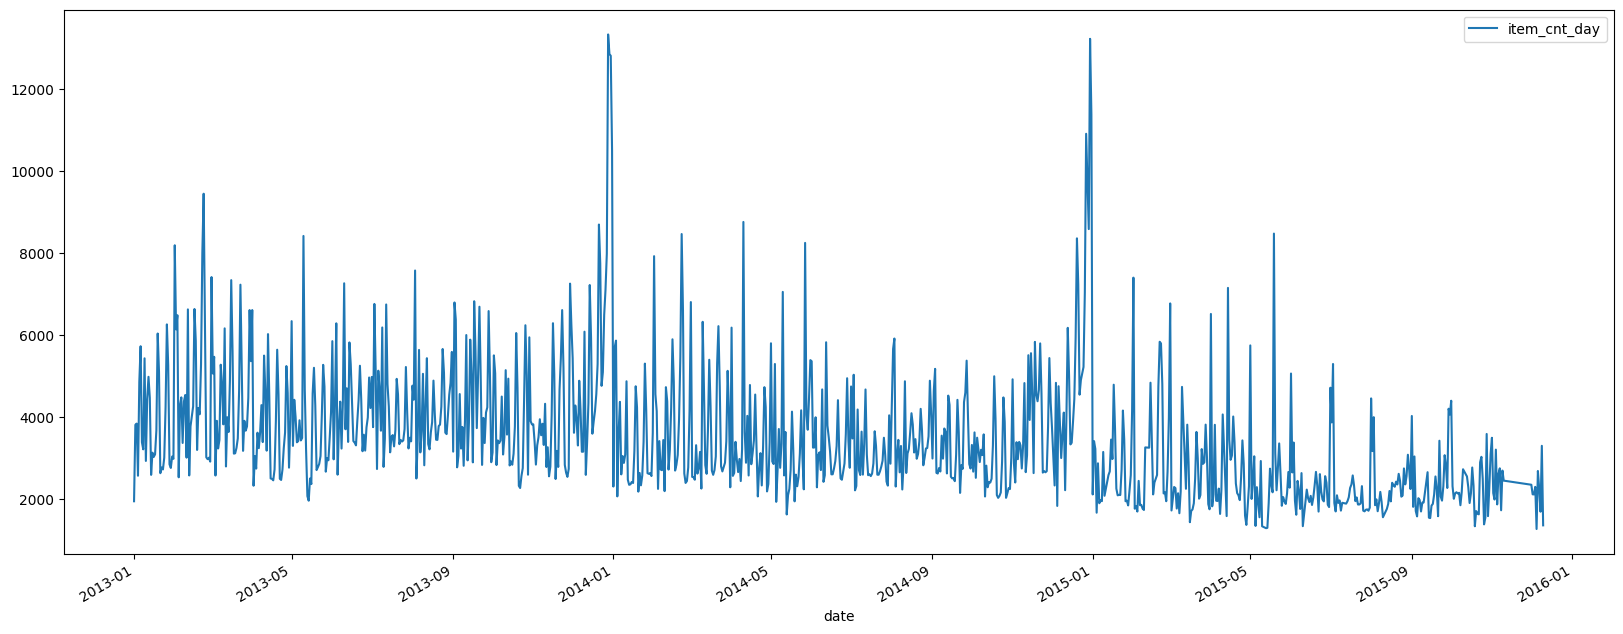

In [10]:
df.plot(figsize=(20, 8));

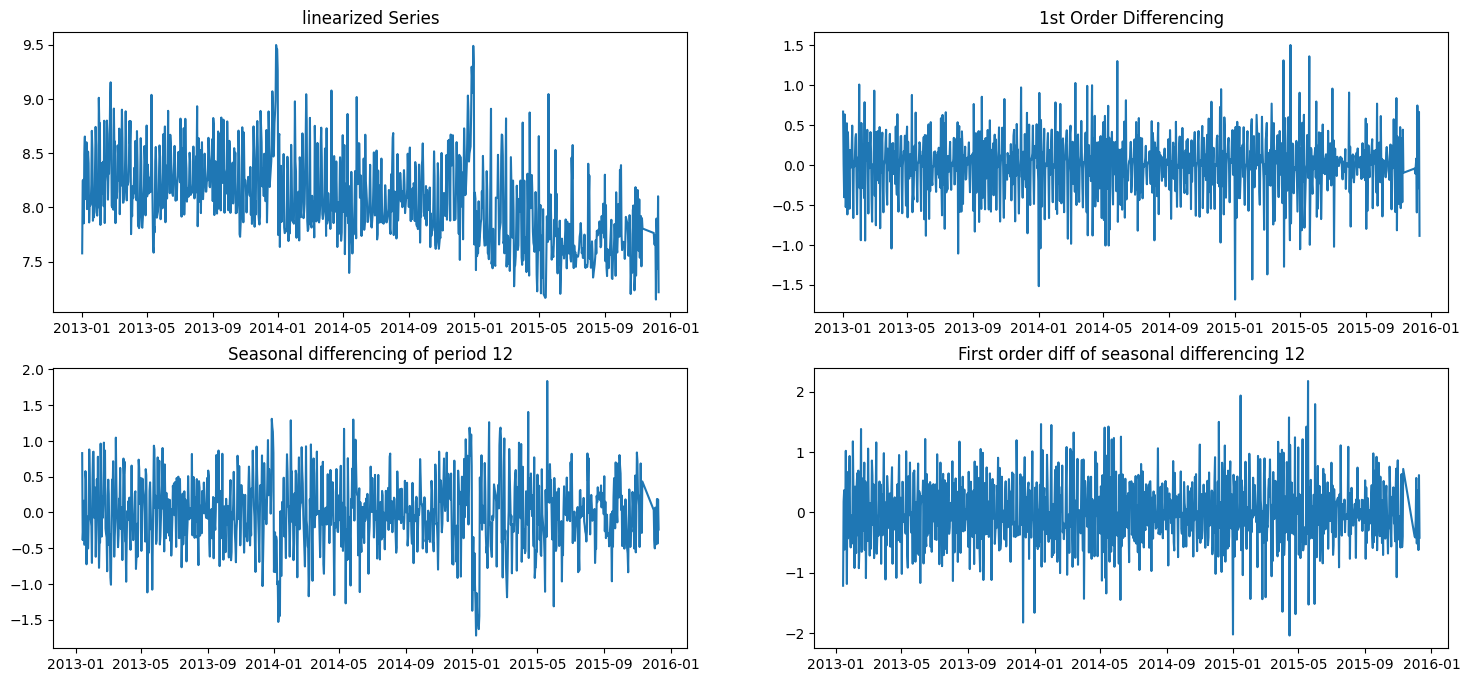

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(18,8))
# keeping just log transform to stay ~ linear
df['log'] = np.log(df.item_cnt_day)

# linearized series
axs[0,0].plot(df.log); axs[0,0].set_title('linearized Series')

# Normal differencing
axs[0,1].plot(df.log.diff(1)); axs[0,1].set_title('1st Order Differencing')

# Seasonal differencing
axs[1,0].plot(df.log.diff(12))
axs[1,0].set_title('Seasonal differencing of period 12')

# Sesonal + Normal differencing
axs[1,1].plot(df.log.diff(12).diff(1))
axs[1,1].set_title('First order diff of seasonal differencing 12');

In [12]:
df['log'] = np.log(df.item_cnt_day)

In [13]:
df.shape

(1034, 2)

In [14]:
train = df.item_cnt_day[0:729]
test = df.item_cnt_day[729:]

In [15]:
smodel = pm.auto_arima(train, seasonal=True, m=4, 
                       start_p=0, max_p=1, max_d=1, start_q=0, max_q=1,
                       start_P=0, max_P=2, max_D=1, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=12809.839, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=12739.131, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=12620.746, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=12807.908, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=12656.412, Time=0.23 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=12615.678, Time=0.69 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=12615.720, Time=0.39 sec
 ARIMA(0,1,1)(2,0,1)[4] intercept   : AIC=12625.732, Time=0.27 sec
 ARIMA(0,1,1)(1,0,2)[4] intercept   : AIC=12625.701, Time=0.30 sec
 ARIMA(0,1,1)(0,0,2)[4] intercept   : AIC=12619.015, Time=0.84 sec
 ARIMA(0,1,1)(2,0,0)[4] intercept   : AIC=12615.965, Time=0.65 sec
 ARIMA(0,1,1)(2,0,2)[4] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=12800.131, Time=0.15 sec
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=12589.817, Time=0.94 sec
 ARIMA(1,1,1)(0,0,1)[4] i

In [17]:
# Build Model
sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 4))
sarima = sarima.fit(maxiter=75)



/Users/eduardocampos/.pyenv/versions/3.8.12/envs/blast-from-the-forecast/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/eduardocampos/.pyenv/versions/3.8.12/envs/blast-from-the-forecast/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.66121D+00    |proj g|=  1.25977D-01

At iterate    5    f=  8.63285D+00    |proj g|=  7.41439D-03

At iterate   10    f=  8.63149D+00    |proj g|=  6.62478D-04

At iterate   15    f=  8.63149D+00    |proj g|=  1.27147D-04

At iterate   20    f=  8.63145D+00    |proj g|=  4.64730D-03

At iterate   25    f=  8.62906D+00    |proj g|=  2.99718D-02

At iterate   30    f=  8.62425D+00    |proj g|=  1.57726D-03

At iterate   35    f=  8.62410D+00    |proj g|=  6.57608D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [19]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      item_cnt_day   No. Observations:                  729
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 4)   Log Likelihood               -6286.965
Date:                           Tue, 22 Nov 2022   AIC                          12583.929
Time:                                   19:56:28   BIC                          12606.881
Sample:                               01-01-2013   HQIC                         12592.785
                                    - 12-30-2014                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3163      0.042      7.615      0.000       0.235       0.398
ma.L1         -0.8916      0.018    -48.724      0.000      -0.927      -0.856
ar.S.L4       -0.4553      0.225     -2.023      0.043      -0.896      -0.014
ma.S.L4        0.3158      0.247      1.279      0.201      -0.168       0.800
sigma2      1.851e+06   6.44e+04     28.750      0.000    1.72e+06    1.98e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):               337.69
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.88
Prob(H) (two-sided):                  0.14   Kurtosis:                         5.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
# Forecast
results = sarima.get_forecast(len(test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

In [29]:
forecast.tail()

2015-10-27    7322.214687
2015-10-28    7322.214687
2015-10-29    7322.214687
2015-10-30    7322.214687
2015-10-31    7322.214687
Freq: D, Name: predicted_mean, dtype: float64

In [30]:
df_day.tail(50)

,date,item_cnt_day
984,2015-09-30,4068.0
985,2015-10-01,4404.0
986,2015-10-02,2318.0
987,2015-10-03,2011.0
988,2015-10-04,2144.0
989,2015-10-05,2171.0
990,2015-10-06,2140.0
991,2015-10-07,2157.0
992,2015-10-08,1854.0
993,2015-10-09,2176.0


In [25]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

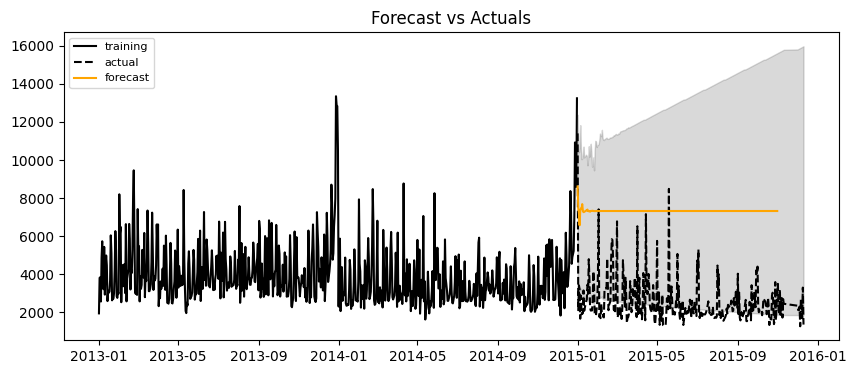

In [27]:
# Reconstruct by taking exponential
forecast_recons = pd.Series((forecast), index=test.index)


plot_forecast(forecast_recons, (train), (test), upper = upper_recons, lower=lower_recons)